# 24/07/07 - Estudos de redes com duas camadas e de 4 a 32 neurônios e peso na perda da condição inicial e dados



## Resumo

- Função de perda: RMSE
- Parânmetros do modelo: k--0.01__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0
- Funções de  ativação: 
    - LeakyReLU
    - Sigmoid
    - Elu 
    - Tanh
    - ReLU
    - SiLU

- Tamanhos de batelada e épocas:
    - (10000, 500)
    - (5000, 1000)

- Arquivo de checkpoint: 1719945754

- Peso da perda de cond. inicial: 10

- Peso da perda de dados: 10

## Análise de erro vs speedup

In [2]:
import glob
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tools import generate_model, train_data

In [3]:
result_list = glob.glob("edo_pinn_sim/*")

print("numero de arquiteturas testadas: {}".format(len(result_list)))

numero de arquiteturas testadas: 196


In [11]:
results_dict = {}

error_list = []

speed_list = []

for file in result_list:
    i = len(error_list)
    if file.split(".")[-1] == "pkl":
        with open(file, "rb") as f:
            aux_dict = pk.load(f)

        results_dict[i] = {
            "rmse": aux_dict["rmse"],
            "max_ae": aux_dict["max_ae"],
            "mean_speed_up": aux_dict["mean_speed_up"],
            "std_speed_up": aux_dict["std_speed_up"],
            "arch_name": file.split("/")[-1].split(".")[0],
            "file": file,
        }

        results_dict[i]["arch_name"] = file.split("/")[-1].split(".")[0]

        error_list.append(results_dict[i]["rmse"] + results_dict[i]["max_ae"])
        speed_list.append(
            results_dict[i]["mean_speed_up"] - results_dict[i]["std_speed_up"]
        )

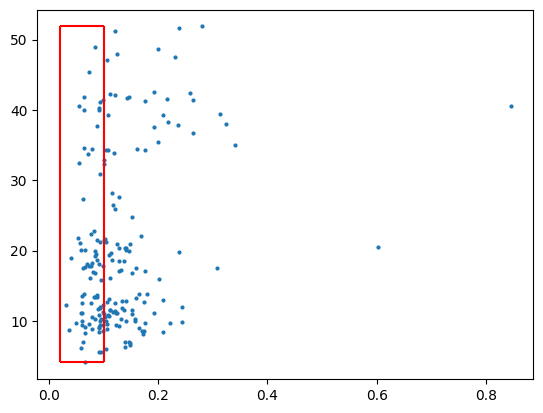

In [12]:
x_lim = (0.02, 0.1)
plt.scatter(error_list, speed_list, s=4)
plt.hlines(max(speed_list), x_lim[0], x_lim[1], color="r")
plt.hlines(min(speed_list), x_lim[0], x_lim[1], color="r")
plt.vlines(x_lim[1], min(speed_list), max(speed_list), color="r")
plt.vlines(x_lim[0], min(speed_list), max(speed_list), color="r")
plt.show()

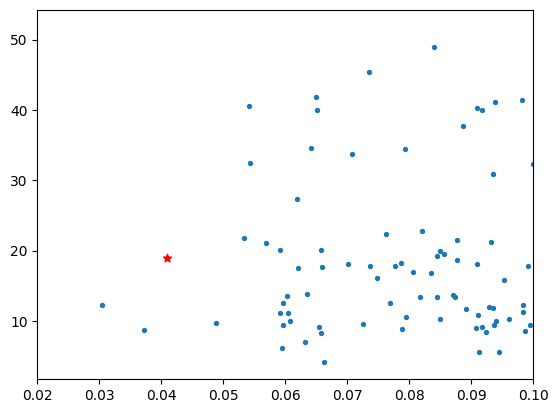

Arquitetura escolhida: epochs_1400__batch_50000__arch_LeakyReLU--4__Tanh--16__
Erro absoluto médio 0.0066176103
Erro absoluto máximo 0.034312367
Speed Up: 19.57014557295725 +/-0.6665235434564675


In [13]:
choice = np.intersect1d(
    np.argwhere(np.array(speed_list) > 15), np.argwhere(np.array(error_list) < 0.05)
)[0]

plt.scatter(error_list, speed_list, s=8)
plt.scatter(error_list[choice], speed_list[choice], c="r", marker="*")
plt.xlim(x_lim[0], x_lim[1])
plt.ylim()
plt.show()

arch_str = results_dict[choice]["arch_name"]

print("Arquitetura escolhida: " + arch_str)
print("Erro absoluto médio", results_dict[choice]["rmse"])
print("Erro absoluto máximo", results_dict[choice]["max_ae"])
print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)

In [15]:
with open("learning_curves/C_pde_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_pde_loss_it = pk.load(f)

with open("learning_curves/C_data_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_data_loss_it = pk.load(f)

with open("learning_curves/C_initial_loss_it__" + arch_str + ".pkl", "rb") as f:
    C_initial_loss_it = pk.load(f)

results_dict[choice]

with open(results_dict[choice]["file"], "rb") as f:
    aux_dict = pk.load(f)
    Cl_pinn_lin = aux_dict["Cl_pinn"].numpy()
    Cp_pinn_lin = aux_dict["Cp_pinn"].numpy()

size_t = int(len(Cl_pinn_lin) ** 0.5)

struct_name = "k--0.01__phi--0.2__ksi--0.0__cb--0.15__Cn_max--0.55__lambd_nb--1.8__mi_n--0.2__lambd_bn--0.1__y_n--0.1__t_lower--0.0__t_upper--10.0"


with open("edo_fdm_sim/Cp__" + struct_name + ".pkl", "rb") as f:
    Cp = pk.load(f)

with open("edo_fdm_sim/Cl__" + struct_name + ".pkl", "rb") as f:
    Cl = pk.load(f)

Cl_pinn_np = Cl_pinn_lin.reshape(size_t, size_t)
Cp_pinn_np = Cp_pinn_lin.reshape(size_t, size_t)

lmb_var = 0.4

lmb_list = np.linspace(
    1.8 * (1 - lmb_var), 1.8 * (1 + lmb_var), num=size_t, endpoint=True
)

t_np = np.linspace(0, 10, num=size_t, endpoint=True)

tt, ll = np.meshgrid(t_np, lmb_list)

In [16]:
data_input_np = np.array([Cl.flatten(), Cp.flatten()]).T

if torch.cuda.is_available():
    device = torch.device("cuda")
    t = (
        torch.tensor(tt, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    lambd_nb = (
        torch.tensor(ll, dtype=torch.float32, requires_grad=True)
        .reshape(-1, 1)
        .to(device)
    )
    data_input = torch.tensor(data_input_np, dtype=torch.float32).to(device)

else:
    device = torch.device("cpu")
    t = torch.tensor(tt, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    lambd_nb = torch.tensor(ll, dtype=torch.float32, requires_grad=True).reshape(-1, 1)
    data_input = torch.tensor(data_input_np, dtype=torch.float32)

n_epochs = int(arch_str.split("__")[0].split("_")[-1])
batch_size = int(arch_str.split("__")[1].split("_")[-1])
model = generate_model(arch_str.split("arch_")[-1]).to(device)

model, nn_loss = train_data(
    n_epochs=n_epochs,
    batch_size=batch_size,
    decay_rate=0.99,
    model=model,
    lambd_nb=lambd_nb,
    device=device,
    data_input=data_input,
    t=t,
)

mesh = torch.cat([t, lambd_nb], dim=1)
with torch.no_grad():
    Cl_pinn_data, Cp_pinn_data = model(mesh).split(1, dim=1)

Cl_pinn_data_np = Cl_pinn_data.reshape(size_t, size_t).cpu().numpy()
Cp_pinn_data_np = Cp_pinn_data.reshape(size_t, size_t).cpu().numpy()

Finished epoch 0, latest loss 0.16844630241394043


KeyboardInterrupt: 

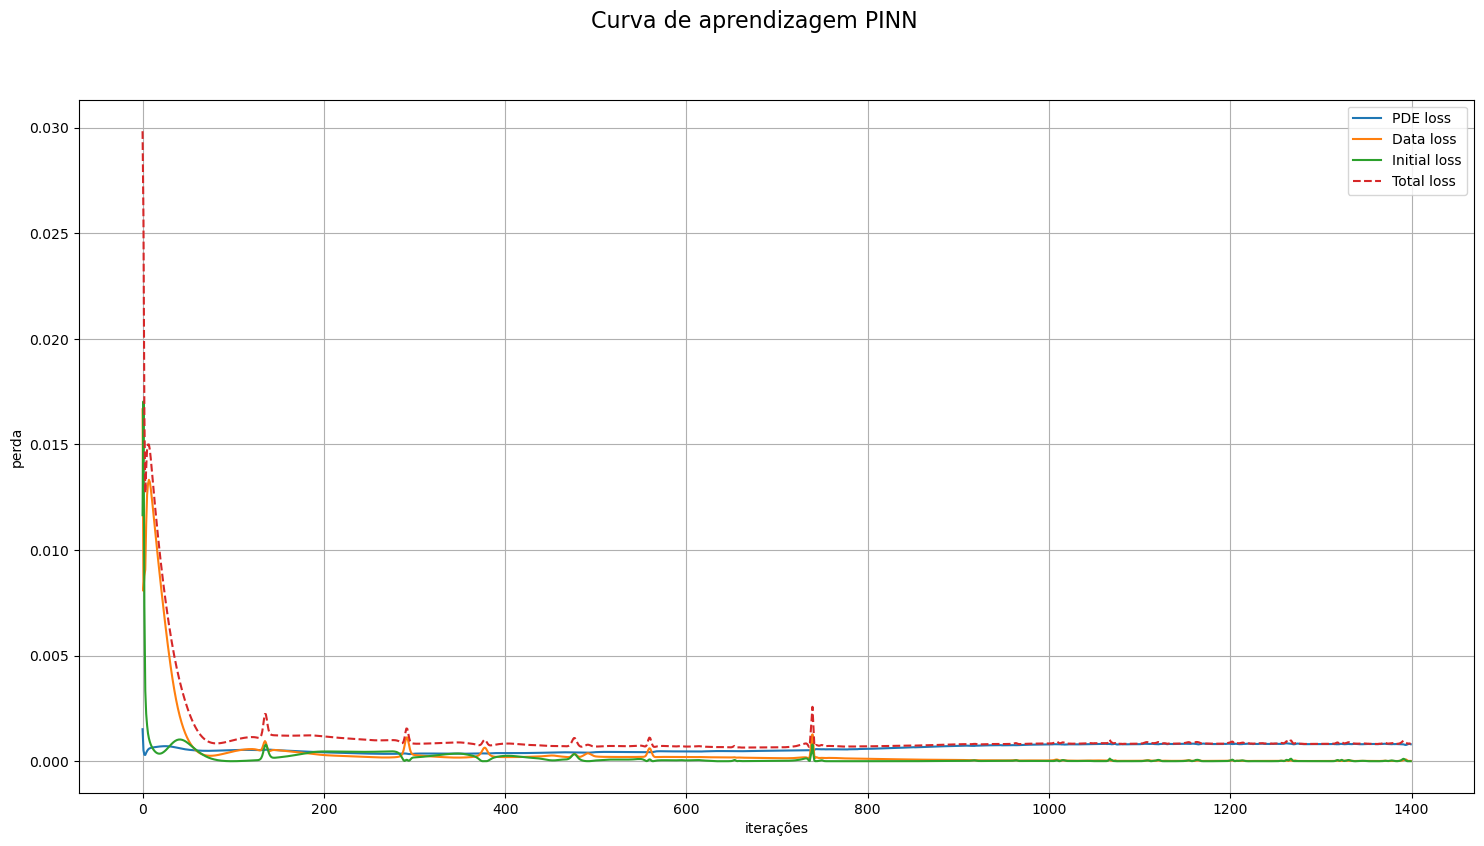

: 

In [16]:
fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem PINN", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(
    range(len(C_pde_loss_it)),
    C_pde_loss_it,
    label="PDE loss",
)
ax.plot(
    range(len(C_data_loss_it)),
    C_data_loss_it,
    label="Data loss",
)
ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it,
    label="Initial loss",
)
ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it + C_data_loss_it + C_pde_loss_it,
    "--",
    label="Total loss",
)

# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

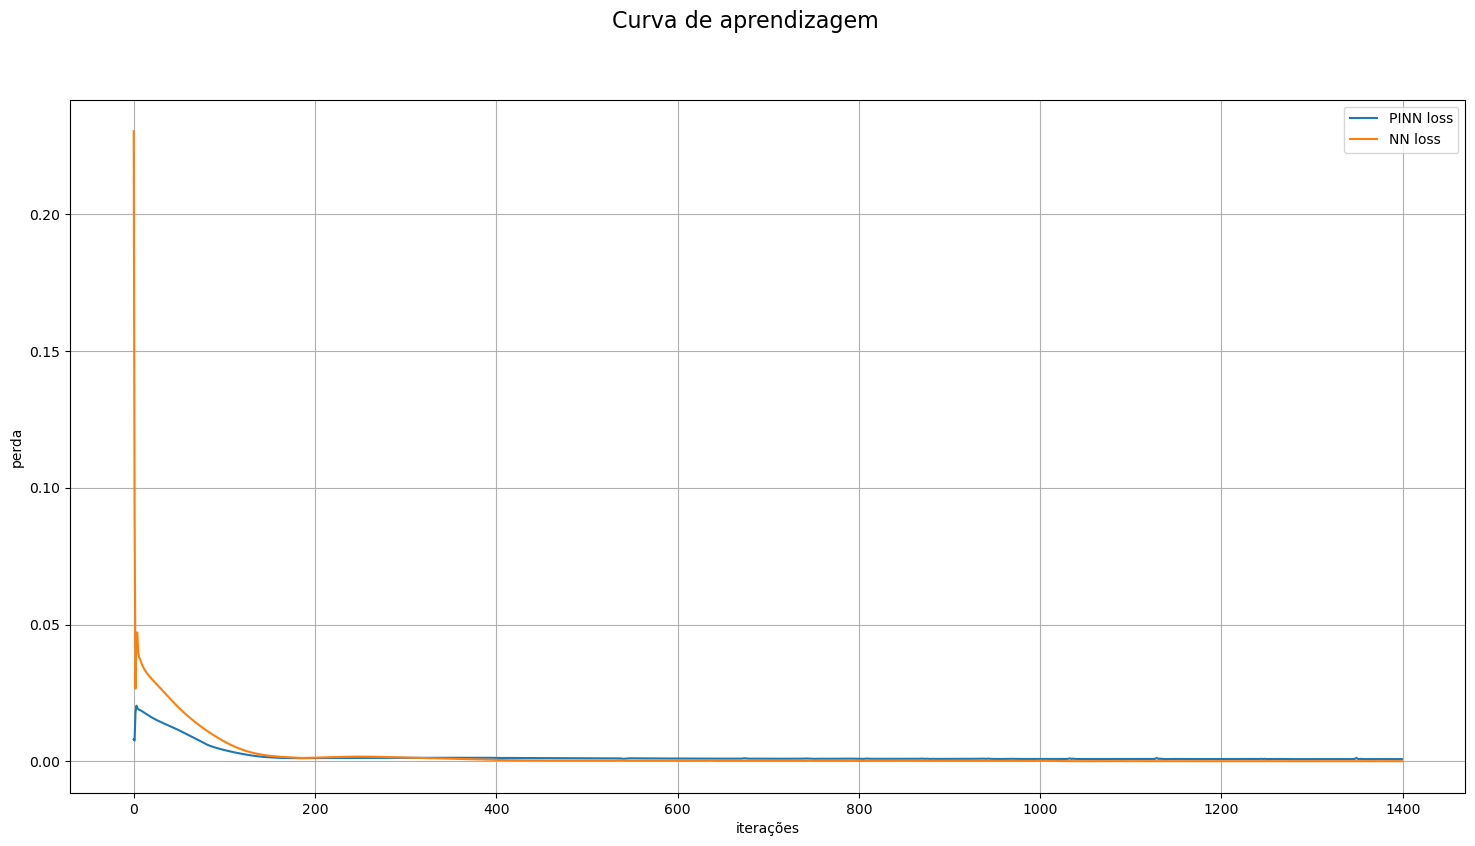

In [10]:
fig = plt.figure(figsize=[18, 9])

fig.suptitle("Curva de aprendizagem", fontsize=16)

# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")

ax.plot(
    range(len(C_initial_loss_it)),
    C_initial_loss_it + C_data_loss_it + C_pde_loss_it,
    label="PINN loss",
)
ax.plot(
    range(len(C_initial_loss_it)),
    nn_loss.cpu().numpy(),
    label="NN loss",
)
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

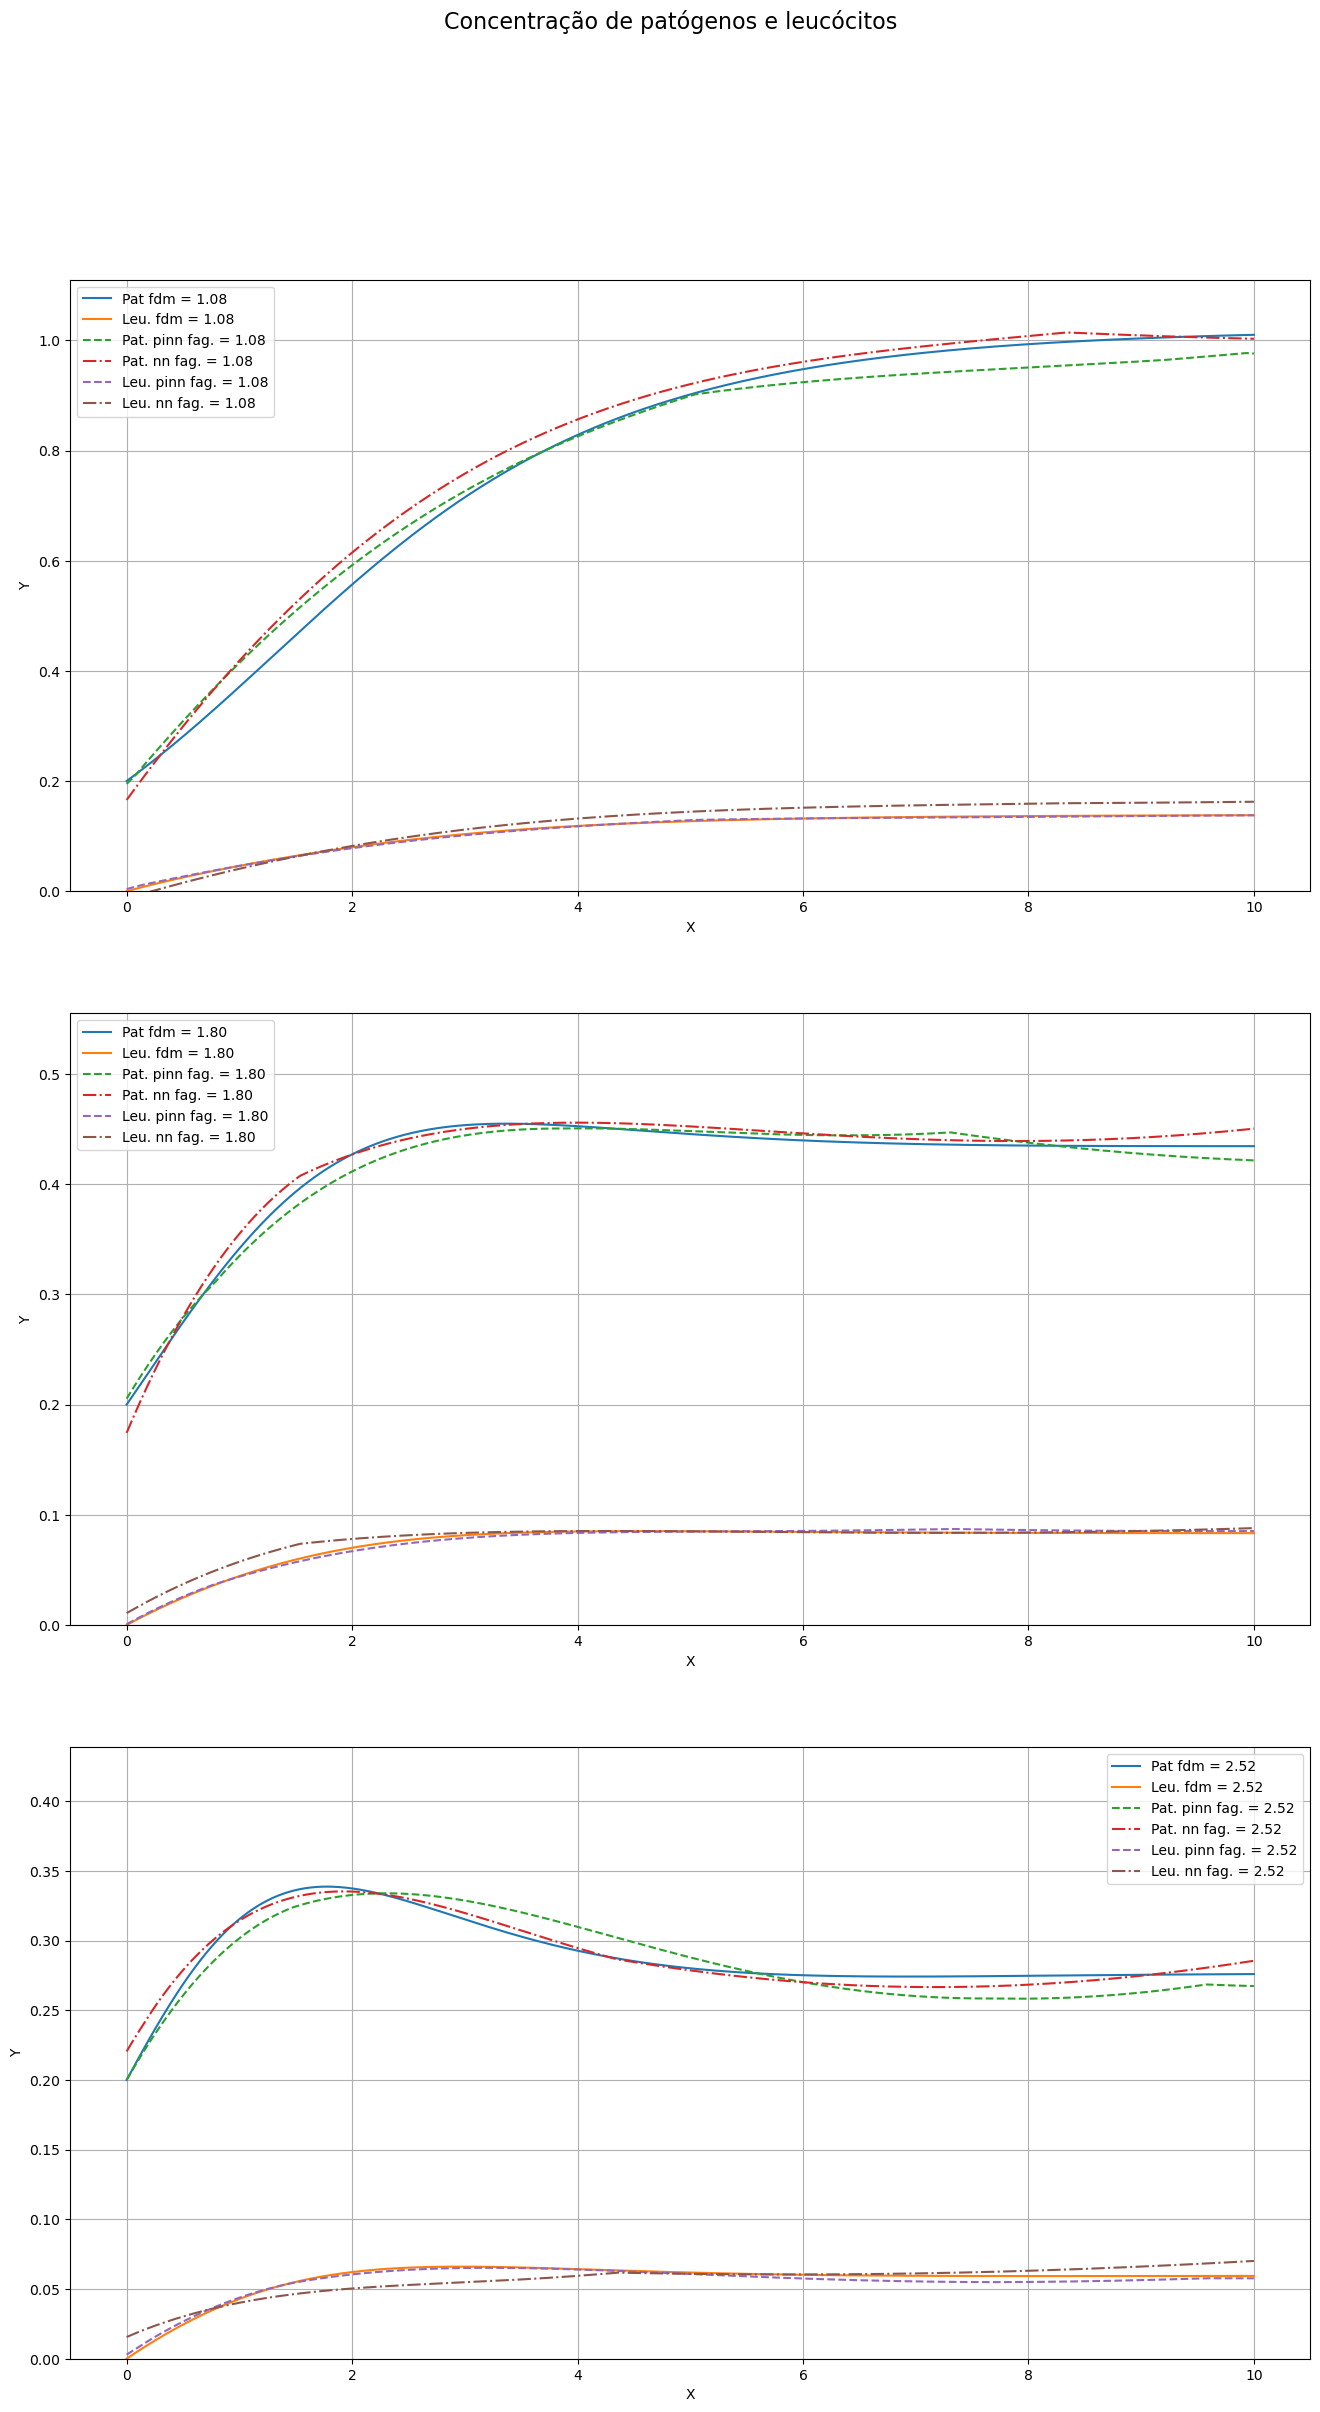

In [11]:
fig = plt.figure(figsize=[16, 27])

fig.suptitle("Concentração de patógenos e leucócitos", fontsize=16)


vmin = 0

cp_real_1 = Cp[0, :]
cl_real_1 = Cl[0, :]
cp_pinn_1 = Cp_pinn_np[0, :]
cl_pinn_1 = Cl_pinn_np[0, :]
cl_pinn_data_1 = Cl_pinn_data_np[0, :]
cp_pinn_data_1 = Cp_pinn_data_np[0, :]
fag_1 = lmb_list[0]

cp_real_2 = Cp[500, :]
cl_real_2 = Cl[500, :]
cp_pinn_2 = Cp_pinn_np[500, :]
cl_pinn_2 = Cl_pinn_np[500, :]
cl_pinn_data_2 = Cl_pinn_data_np[500, :]
cp_pinn_data_2 = Cp_pinn_data_np[500, :]
fag_2 = lmb_list[500]

cp_real_3 = Cp[1000, :]
cl_real_3 = Cl[1000, :]
cp_pinn_3 = Cp_pinn_np[1000, :]
cl_pinn_3 = Cl_pinn_np[1000, :]
cl_pinn_data_3 = Cl_pinn_data_np[1000, :]
cp_pinn_data_3 = Cp_pinn_data_np[1000, :]
fag_3 = lmb_list[1000]

# Plotango 3D
ax = fig.add_subplot(3, 1, 1)

ax.plot(t_np, cp_real_1, label="Pat fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cl_real_1, label="Leu. fdm = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_1, "--", label="Pat. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cp_pinn_data_1, "-.", label="Pat. nn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_1, "--", label="Leu. pinn fag. = {:.2f}".format(fag_1))
ax.plot(t_np, cl_pinn_data_1, "-.", label="Leu. nn fag. = {:.2f}".format(fag_1))
ax.set_xlabel("X")
ax.set_ylabel("Y")

vmax = np.max(
    [
        np.max(cp_real_1),
        np.max(cl_real_1),
        np.max(cp_pinn_1),
        np.max(cl_pinn_1),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 2)

ax.plot(t_np, cp_real_2, label="Pat fdm = {:.2f}".format(fag_2))
ax.plot(t_np, cl_real_2, label="Leu. fdm = {:.2f}".format(fag_2))
ax.plot(t_np, cp_pinn_2, "--", label="Pat. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cp_pinn_data_2, "-.", label="Pat. nn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_2, "--", label="Leu. pinn fag. = {:.2f}".format(fag_2))
ax.plot(t_np, cl_pinn_data_2, "-.", label="Leu. nn fag. = {:.2f}".format(fag_2))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_2),
        np.max(cl_real_2),
        np.max(cp_pinn_2),
        np.max(cl_pinn_2),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

ax = fig.add_subplot(3, 1, 3)

ax.plot(t_np, cp_real_3, label="Pat fdm = {:.2f}".format(fag_3))
ax.plot(t_np, cl_real_3, label="Leu. fdm = {:.2f}".format(fag_3))
ax.plot(t_np, cp_pinn_3, "--", label="Pat. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cp_pinn_data_3, "-.", label="Pat. nn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_3, "--", label="Leu. pinn fag. = {:.2f}".format(fag_3))
ax.plot(t_np, cl_pinn_data_3, "-.", label="Leu. nn fag. = {:.2f}".format(fag_3))
ax.set_xlabel("X")
ax.set_ylabel("Y")
vmax = np.max(
    [
        np.max(cp_real_3),
        np.max(cl_real_3),
        np.max(cp_pinn_3),
        np.max(cl_pinn_3),
    ]
)
ax.set_ylim(vmin, vmax + 0.1)
ax.legend()
ax.grid()

plt.show()

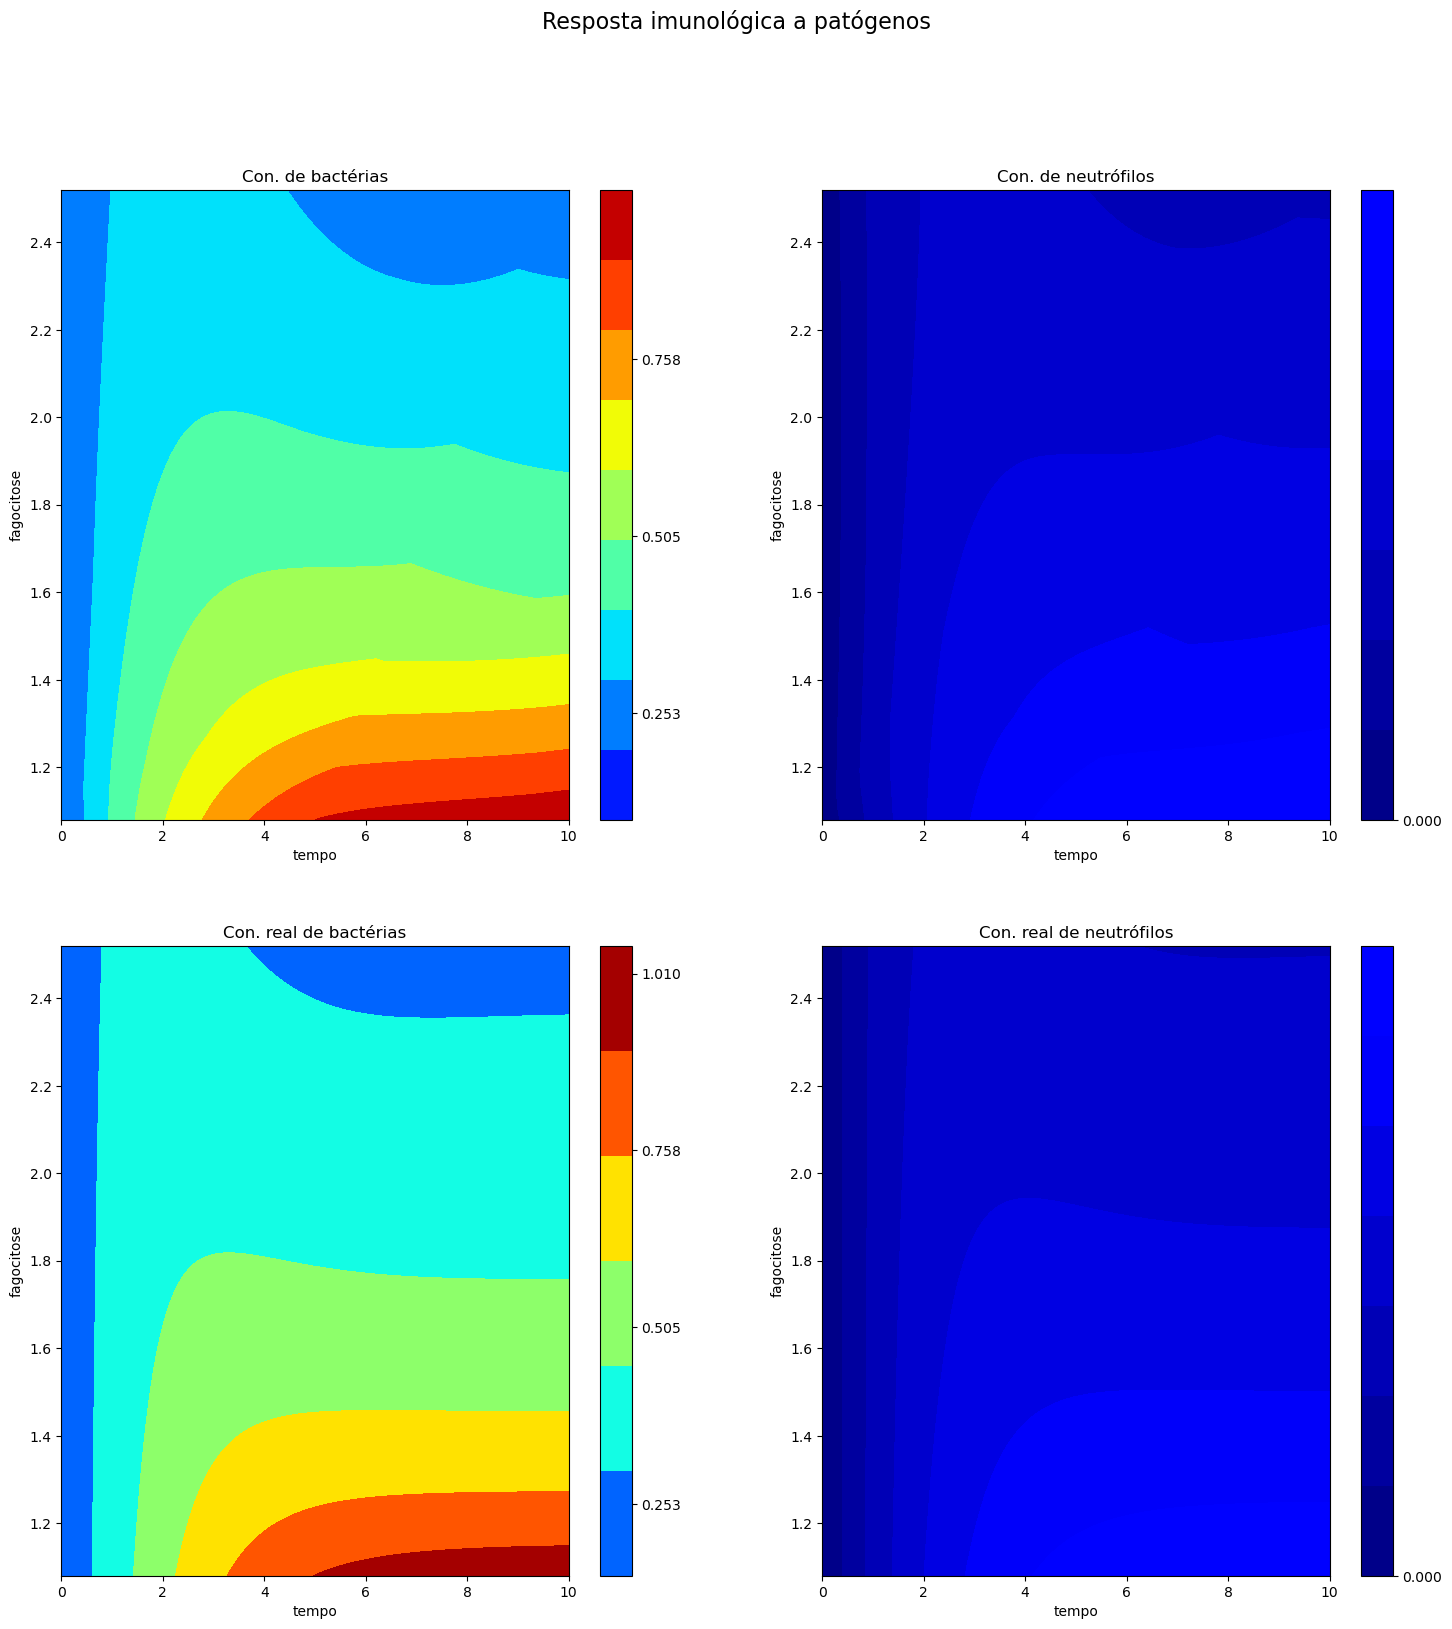

Speed Up: 48.9284579561603 +/-8.363353275197165


In [12]:
fig = plt.figure(figsize=[18, 18])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

vmin = 0
vmax = np.max(
    [
        np.max(Cl_pinn_lin),
        np.max(Cp_pinn_lin),
        np.max(Cp),
        np.max(Cl),
    ]
)

# Plotango 3D
ax = fig.add_subplot(2, 2, 1)

contour = ax.contourf(
    tt,
    ll,
    Cp_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 2)

contour = ax.contourf(
    tt,
    ll,
    Cl_pinn_np,
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotango 3D
ax = fig.add_subplot(2, 2, 3)

contour = ax.contourf(
    tt,
    ll,
    Cp.reshape(size_t, size_t),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de bactérias")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")
colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

# Plotando 2D

ax = fig.add_subplot(2, 2, 4)

contour = ax.contourf(
    tt,
    ll,
    Cl.reshape(size_t, size_t),
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)
ax.set_title("Con. real de neutrófilos")
ax.set_xlabel("tempo")
ax.set_ylabel("fagocitose")

colobar = fig.colorbar(contour, ticks=np.linspace(vmin, vmax, num=5))

plt.show()

print(
    "Speed Up: {} +/-{}".format(
        results_dict[choice]["mean_speed_up"], results_dict[choice]["std_speed_up"]
    )
)